<a href="https://www.kaggle.com/code/ouzhansalam/yolov8-object-detection?scriptVersionId=249261474" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
import json
import os
from collections import defaultdict

# Dataset path'leri
json_path = "/kaggle/input/flir-thermal-images-dataset/FLIR_ADAS_1_3/train/thermal_annotations.json"
images_dir = "/kaggle/input/flir-thermal-images-dataset/FLIR_ADAS_1_3/train/Annotated_thermal_8_bit"
output_dir = "/kaggle/working/labels_yolo"
os.makedirs(output_dir, exist_ok=True)

# JSON'u yükle
with open(json_path, "r") as f:
    data = json.load(f)

# image_id -> filename eşle
image_id_to_info = {}
for img in data['images']:
    image_id_to_info[img['id']] = {
        'file_name': img['file_name'],
        'width': img['width'],
        'height': img['height']
    }

# category_id -> name eşle
category_id_to_name = {cat['id']: cat['name'] for cat in data['categories']}

# Sadece 'person' ve 'car'
class_map = {
    'person': 0,
    'car': 1
}

# Annotations -> YOLO format
labels = defaultdict(list)
for ann in data['annotations']:
    img_id = ann['image_id']
    cat_id = ann['category_id']
    bbox = ann['bbox']  # [x, y, width, height]


In [ ]:
import os

labels_path = "/kaggle/working/labels_yolo"

# Tüm txt dosyalarını listele
yolo_files = []
for root, _, files in os.walk(labels_path):
    for file in files:
        if file.endswith(".txt"):
            yolo_files.append(os.path.join(root, file))

# Sıralı al (düzeni için)
yolo_files.sort()

# İlk 10 dosyayı yazdır
for file_path in yolo_files[:2]:
    print(f"\n---- {file_path} ----")
    with open(file_path, "r") as f:
        print(f.read())


In [5]:
import json
import os
import shutil
from collections import defaultdict

# Dataset kök yolu
dataset_root = "/kaggle/working/datasets"
label_train_dir = os.path.join(dataset_root, "labels/train")
label_val_dir = os.path.join(dataset_root, "labels/val")
image_train_dir = os.path.join(dataset_root, "images/train")
image_val_dir = os.path.join(dataset_root, "images/val")

for path in [label_train_dir, label_val_dir, image_train_dir, image_val_dir]:
    os.makedirs(path, exist_ok=True)

# JSON ve orijinal image dizinleri
json_paths = {
    "train": "/kaggle/input/flir-thermal-images-dataset/FLIR_ADAS_1_3/train/thermal_annotations.json",
    "val": "/kaggle/input/flir-thermal-images-dataset/FLIR_ADAS_1_3/val/thermal_annotations.json"
}
image_dirs = {
    "train": "/kaggle/input/flir-thermal-images-dataset/FLIR_ADAS_1_3/train",
    "val": "/kaggle/input/flir-thermal-images-dataset/FLIR_ADAS_1_3/val"
}

# category_id -> name eşle
class_map = {'person': 0, 'car': 1}

for split in ["train", "val"]:
    print(f"\n📂 {split.upper()} dataset işleniyor...")

    # JSON yükle
    with open(json_paths[split], "r") as f:
        data = json.load(f)

    # image_id -> info eşle
    image_id_to_info = {}
    for img in data['images']:
        image_id_to_info[img['id']] = {
            'file_name': img['file_name'],
            'width': img['width'],
            'height': img['height']
        }

    # category_id -> name eşle
    category_id_to_name = {cat['id']: cat['name'] for cat in data['categories']}

    # image_id -> label stringleri
    labels = defaultdict(list)
    for ann in data['annotations']:
        img_id = ann['image_id']
        cat_id = ann['category_id']
        bbox = ann['bbox']
        cat_name = category_id_to_name[cat_id]
        
        if cat_name not in class_map:
            continue
        
        x, y, w, h = bbox
        info = image_id_to_info[img_id]
        img_w, img_h = info['width'], info['height']

        if w < 5 or h < 5 or w / img_w < 0.01 or h / img_h < 0.01:
            continue
        if w / h > 10 or h / w > 10:
            continue

        x_center = (x + w/2) / img_w
        y_center = (y + h/2) / img_h
        w_norm = w / img_w
        h_norm = h / img_h

        labels[img_id].append(
            f"{class_map[cat_name]} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}"
        )

    # TXT + image dosyalarını oluştur
    for img_id, info in image_id_to_info.items():
        file_name = os.path.basename(info['file_name'])
        txt_file_name = os.path.splitext(file_name)[0] + ".txt"

        if split == "train":
            txt_path = os.path.join(label_train_dir, txt_file_name)
            img_dst_path = os.path.join(image_train_dir, file_name)
        else:
            txt_path = os.path.join(label_val_dir, txt_file_name)
            img_dst_path = os.path.join(image_val_dir, file_name)

        # label yaz
        with open(txt_path, "w") as f:
            if img_id in labels:
                f.write("\n".join(labels[img_id]) + "\n")
        
        # resmi kopyala
        orig_img_path = os.path.join(image_dirs[split], info['file_name'])
        if os.path.exists(orig_img_path):
            shutil.copy(orig_img_path, img_dst_path)
        else:
            print(f"⚠️ Resim bulunamadı: {orig_img_path}")

print("\n✅ JSON -> YOLO dataset tamamen hazırlandı.")



📂 TRAIN dataset işleniyor...

📂 VAL dataset işleniyor...

✅ JSON -> YOLO dataset tamamen hazırlandı.


In [6]:
import os
import shutil

# Klasör yolları
image_val_dir = "/kaggle/working/datasets/images/val"
label_val_dir = "/kaggle/working/datasets/labels/val"
image_test_dir = "/kaggle/working/datasets/images/test"
label_test_dir = "/kaggle/working/datasets/labels/test"

# Test klasörlerini oluştur
os.makedirs(image_test_dir, exist_ok=True)
os.makedirs(label_test_dir, exist_ok=True)

# Val içindeki tüm görselleri listele ve sıralı hale getir
images = sorted([f for f in os.listdir(image_val_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))])

# İstediğin split
split_index = 1200
val_images = images[:split_index]
test_images = images[split_index:]

# Test için seçilenleri taşı
for img_file in test_images:
    # Görseli taşı
    shutil.move(
        os.path.join(image_val_dir, img_file),
        os.path.join(image_test_dir, img_file)
    )
    # Label'i taşı
    txt_file = os.path.splitext(img_file)[0] + ".txt"
    shutil.move(
        os.path.join(label_val_dir, txt_file),
        os.path.join(label_test_dir, txt_file)
    )

print(f"✅ Val klasöründe toplam: {len(images)} görüntü vardı.")
print(f"➡️  Şimdi val: {len(val_images)} görüntü, test: {len(test_images)} görüntü.")

✅ Val klasöründe toplam: 1366 görüntü vardı.
➡️  Şimdi val: 1200 görüntü, test: 166 görüntü.


In [ ]:
import cv2
import matplotlib.pyplot as plt
import os

# Klasör yolları
dataset_root = "/kaggle/working/datasets"
image_train_dir = os.path.join(dataset_root, "images/train")
image_val_dir = os.path.join(dataset_root, "images/val")
image_test_dir = os.path.join(dataset_root, "images/test")

# Her klasörden ilk görüntüyü bul
def get_first_image(directory):
    images = sorted([f for f in os.listdir(directory) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    if images:
        return os.path.join(directory, images[0])
    else:
        return None

train_image = get_first_image(image_train_dir)
val_image = get_first_image(image_val_dir)
test_image = get_first_image(image_test_dir)

# Görselleri çiz
plt.figure(figsize=(15,5))

# Train
plt.subplot(1, 3, 1)
if train_image:
    img = cv2.imread(train_image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title("First Train Image")
    plt.axis("off")
else:
    plt.text(0.5, 0.5, "No train image", ha='center', va='center', fontsize=12)
    plt.axis("off")

# Val
plt.subplot(1, 3, 2)
if val_image:
    img = cv2.imread(val_image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title("First Val Image")
    plt.axis("off")
else:
    plt.text(0.5, 0.5, "No val image", ha='center', va='center', fontsize=12)
    plt.axis("off")

# Test
plt.subplot(1, 3, 3)
if test_image:
    img = cv2.imread(test_image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title("First Test Image")
    plt.axis("off")
else:
    plt.text(0.5, 0.5, "No test image", ha='center', va='center', fontsize=12)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
yaml_content = """
path: /kaggle/working/datasets
train: images/train
val: images/val

nc: 2
names: ['person', 'car']
"""

with open("/kaggle/working/thermal.yaml", "w") as f:
    f.write(yaml_content.strip())

print("✅ thermal.yaml dosyası oluşturuldu -> /kaggle/working/thermal.yaml")


In [ ]:
import os

def check_dir_structure(base_dir):
    folders = [
        "images/train", "images/val",
        "labels/train", "labels/val"
    ]
    for folder in folders:
        path = os.path.join(base_dir, folder)
        if not os.path.exists(path):
            print(f"❌ {folder} bulunamadı.")
        else:
            files = os.listdir(path)
            image_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'))]
            label_files = [f for f in files if f.lower().endswith('.txt')]
            
            print(f"📂 {folder}:")
            print(f"    Toplam dosya: {len(files)}")
            if "images" in folder:
                print(f"    Görsel sayısı: {len(image_files)}")
            else:
                print(f"    Label sayısı : {len(label_files)}")
            if len(files) == 0:
                print("    ⚠️ Klasör boş!")

# Kullanım
check_dir_structure("/kaggle/working/datasets")


In [ ]:
!pip install ultralytics

In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8m.pt")  # daha büyük model

# Daha iyi augmentasyon + scheduler
model.train(
    data="/kaggle/working/thermal.yaml",
    epochs=15,
    imgsz=640,
    batch=16,
    patience=10,
    degrees=5,      # daha az rotate
    scale=0.2,      # %20 scale zoom
    shear=1,        # hafif shear
    perspective=0,  # neredeyse hiç perspective bozma
    flipud=0,       # dikey flip kapalı
    hsv_h=0, hsv_s=0, hsv_v=0, # renk augment kapalı
    mosaic=0.5,     # daha hafif mosaic
    mixup=0.05,     # hafif mixup
    lr0=0.001,      # daha düşük başlangıç
    lrf=0.1,
    warmup_epochs=3
)


In [1]:
import os
# 🔥 Görsellerin yolu
img_dir = "/kaggle/input/flir-thermal-images-dataset/FLIR_ADAS_1_3/val/thermal_8_bit"

# Tüm görselleri alfabetik sıraya koy
all_images = [os.path.join(img_dir, fname) for fname in sorted(os.listdir(img_dir)) if fname.endswith(".jpeg")]

# İlk 1200'ü atla, kalanları test için al
test_images = all_images[1200:]

print(f"Toplam {len(all_images)} görsel var.")
print(f"İlk 1200 atlandı, test için {len(test_images)} görsel kullanılacak.")

Toplam 1366 görsel var.
İlk 1200 atlandı, test için 166 görsel kullanılacak.


Test annotated klasöründe son 166 görsel seçildi. Toplam: 166

 FLIR_10063.jpeg | Ground Truth Counts: {'person': 5, 'car': 4}

image 1/1 /kaggle/working/datasets/images/test/FLIR_10063.jpeg: 512x640 4 persons, 2 cars, 1 stop sign, 43.6ms
Speed: 5.0ms preprocess, 43.6ms inference, 161.0ms postprocess per image at shape (1, 3, 512, 640)


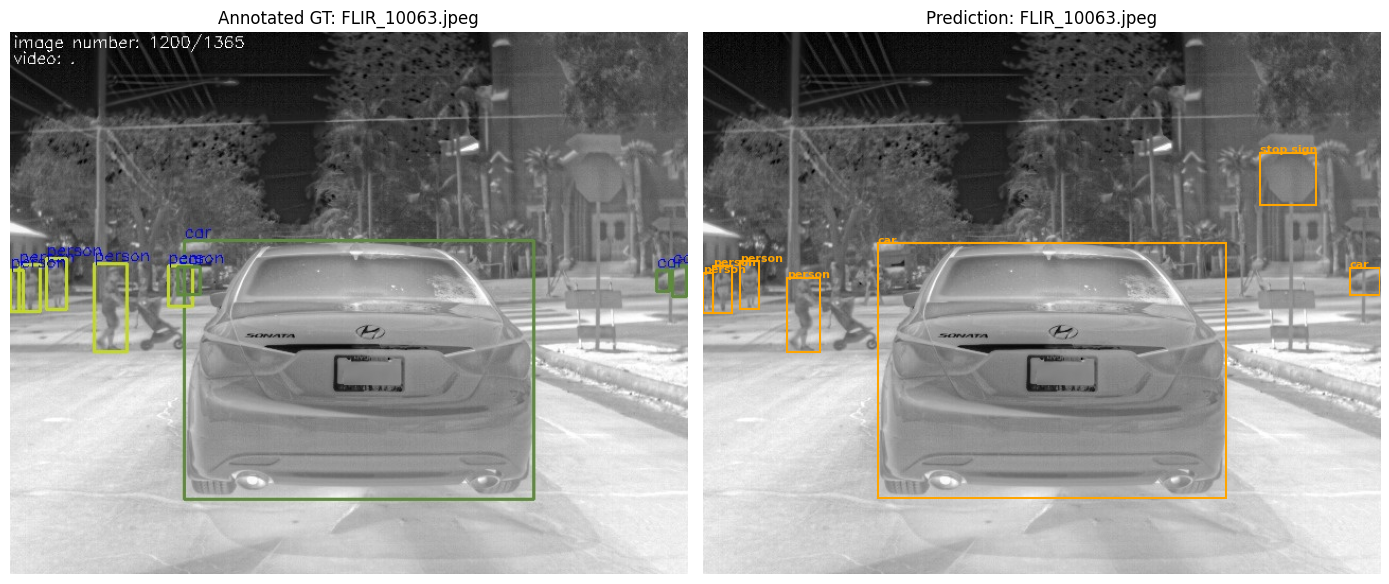


 FLIR_10064.jpeg | Ground Truth Counts: {'person': 1, 'car': 4}

image 1/1 /kaggle/working/datasets/images/test/FLIR_10064.jpeg: 512x640 1 person, 3 cars, 1 stop sign, 15.0ms
Speed: 1.3ms preprocess, 15.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


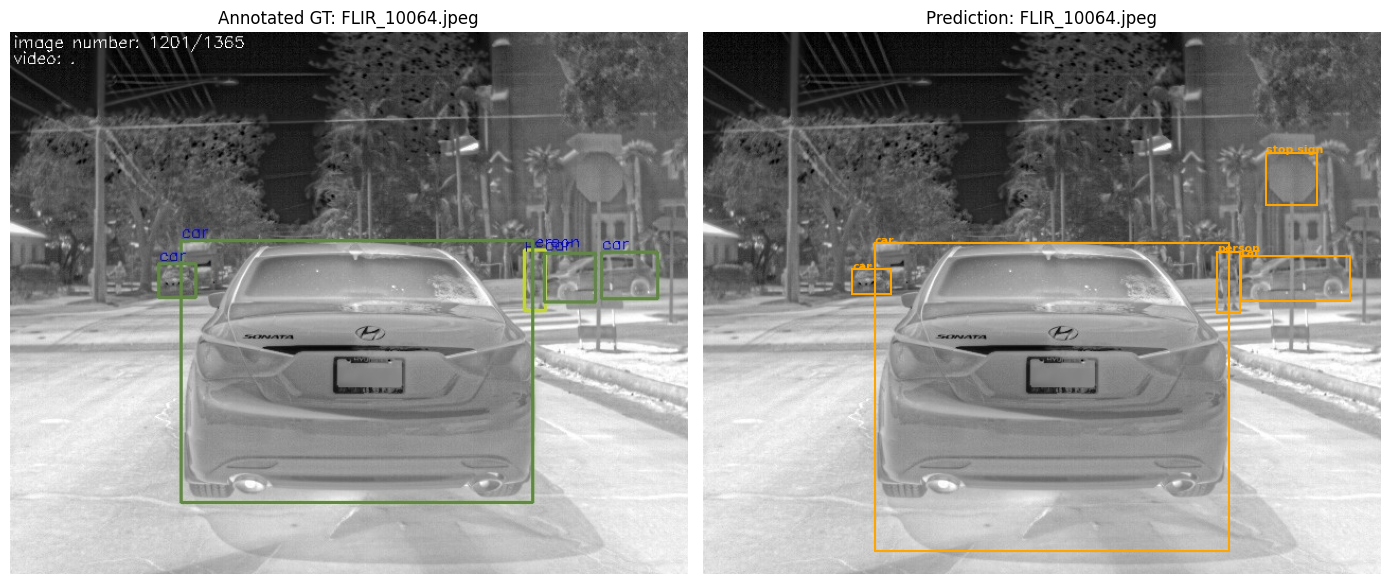


 FLIR_10065.jpeg | Ground Truth Counts: {'person': 1, 'car': 3}

image 1/1 /kaggle/working/datasets/images/test/FLIR_10065.jpeg: 512x640 1 person, 3 cars, 15.0ms
Speed: 1.3ms preprocess, 15.0ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 640)


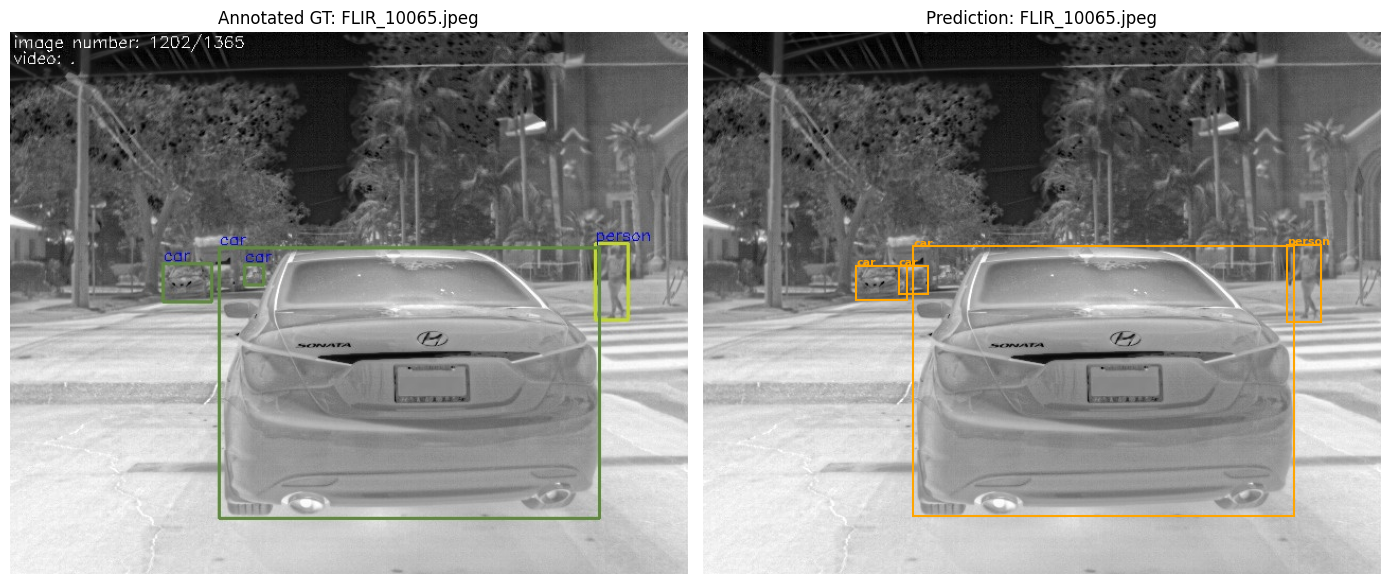


 FLIR_10066.jpeg | Ground Truth Counts: {'car': 3, 'person': 2}

image 1/1 /kaggle/working/datasets/images/test/FLIR_10066.jpeg: 512x640 2 persons, 3 cars, 15.0ms
Speed: 1.3ms preprocess, 15.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


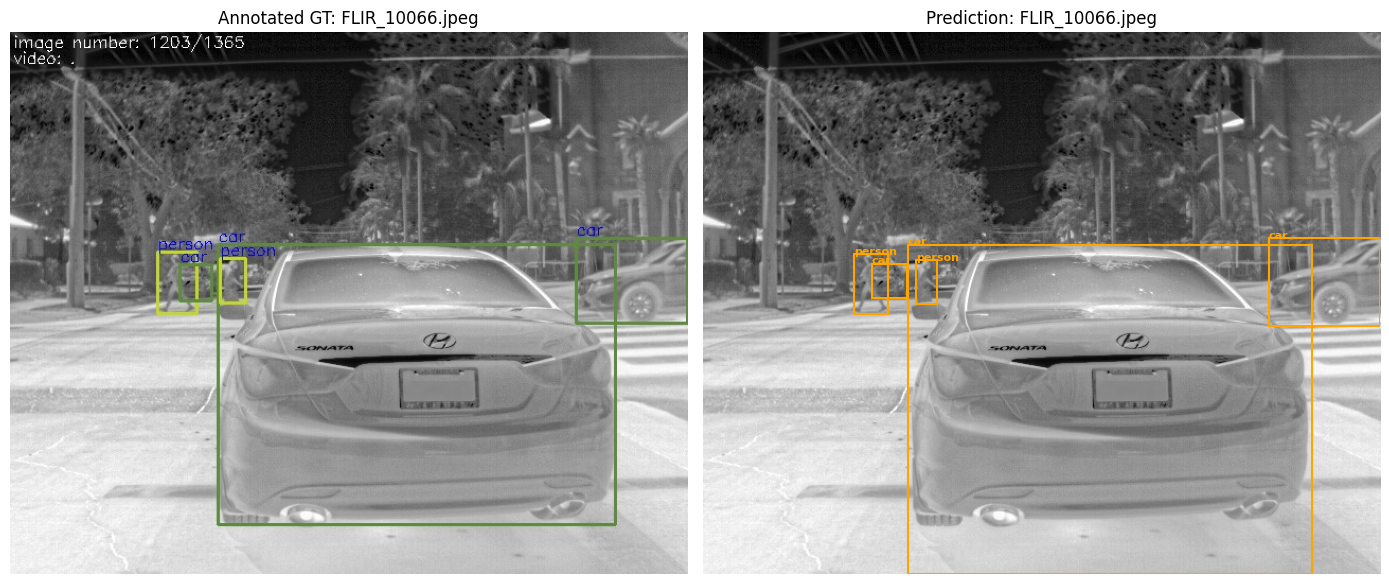


 FLIR_10067.jpeg | Ground Truth Counts: {'person': 1, 'car': 8}

image 1/1 /kaggle/working/datasets/images/test/FLIR_10067.jpeg: 512x640 1 person, 9 cars, 1 elephant, 14.9ms
Speed: 1.6ms preprocess, 14.9ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)


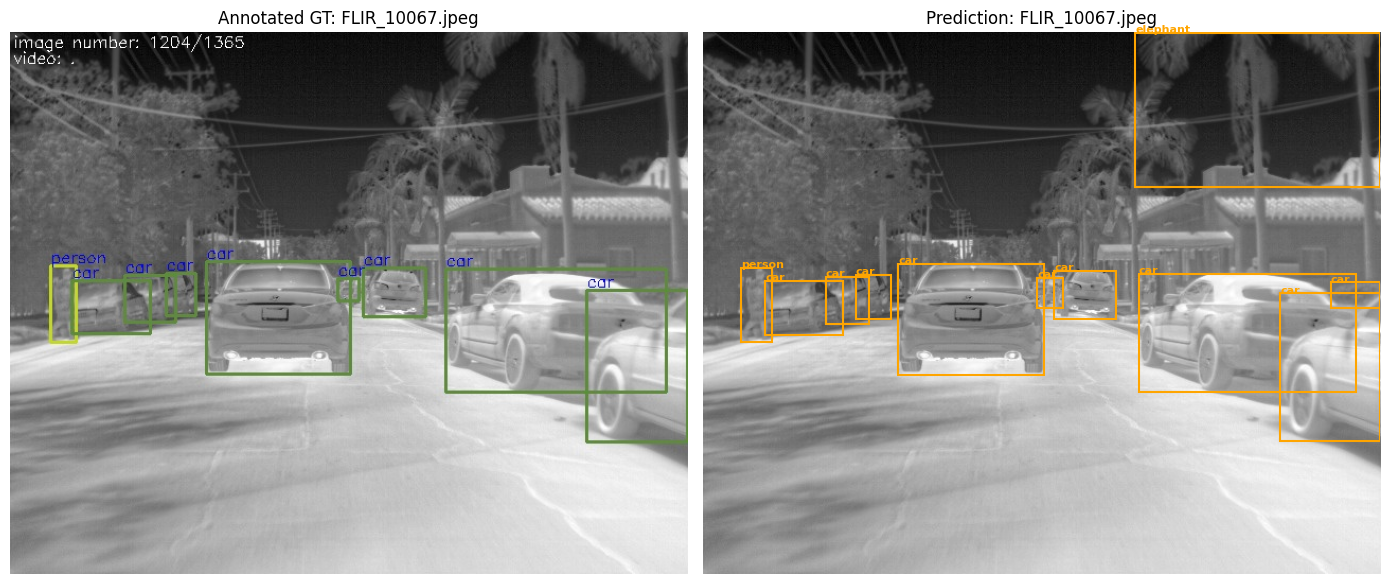

In [1]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from collections import Counter

# 🔥 Model yükle
model = YOLO("/kaggle/input/termal_model/pytorch/default/1/termal_model.pt")
class_map = model.names  # ör: {0: 'person', 1: 'car'}

# 🔥 Klasör yolları
img_dir_test = "/kaggle/working/datasets/images/test"
label_dir_test = "/kaggle/working/datasets/labels/test"
img_dir_annotated = "/kaggle/input/flir-thermal-images-dataset/FLIR_ADAS_1_3/val/Annotated_thermal_8_bit"

# 🔥 Test görselleri
test_images = sorted([f for f in os.listdir(img_dir_annotated) if f.endswith(('.jpeg','.jpg','.png'))])[-166:]
print(f"Test annotated klasöründe son 166 görsel seçildi. Toplam: {len(test_images)}")

# 🔥 GT sınıf isimleri (sen YOLO label için 0=person, 1=car yapmıştın)
gt_class_map = {0: 'person', 1: 'car'}

for file_name in test_images[:5]:
    img_path_annotated = os.path.join(img_dir_annotated, file_name)
    img_path_test = os.path.join(img_dir_test, file_name)
    label_path_test = os.path.join(label_dir_test, os.path.splitext(file_name)[0] + ".txt")

    # Annotated (zaten kutulu) görüntüyü oku
    img_annotated = cv2.imread(img_path_annotated)
    img_annotated = cv2.cvtColor(img_annotated, cv2.COLOR_BGR2RGB)

    # Model için test görüntüsünü oku
    img_test = cv2.imread(img_path_test)
    img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)

    # ================================
    # Konsola gerçek kutu istatistiklerini yaz
    gt_classes = []
    if os.path.exists(label_path_test):
        with open(label_path_test, "r") as f:
            lines = f.readlines()
        for line in lines:
            cls_id, _, _, _, _ = map(float, line.strip().split())
            cls_name = gt_class_map.get(int(cls_id), f"id:{int(cls_id)}")
            gt_classes.append(cls_name)
        gt_count = Counter(gt_classes)
        print(f"\n {file_name} | Ground Truth Counts: {dict(gt_count)}")
    else:
        print(f"\n {file_name} | No ground truth labels found!")

    # ================================
    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(14, 7))

    # SOL: Annotated
    axs[0].imshow(img_annotated)
    axs[0].set_title(f"Annotated GT: {file_name}")
    axs[0].axis("off")

    # SAĞ: Prediction
    axs[1].imshow(img_test)
    axs[1].set_title(f"Prediction: {file_name}")
    axs[1].axis("off")

    results = model.predict(img_path_test, save=False, imgsz=640, conf=0.25)
    preds = results[0].boxes
    for box, cls_id in zip(preds.xywh, preds.cls):
        xc, yc, bw, bh = box.tolist()
        x1 = (xc - bw/2)
        y1 = (yc - bh/2)
        rect = patches.Rectangle((x1, y1), bw, bh, linewidth=1.5, edgecolor='orange', facecolor='none')
        axs[1].add_patch(rect)
        axs[1].text(x1, y1, class_map.get(int(cls_id), str(int(cls_id))), color='orange', fontsize=8, weight='bold')

    plt.tight_layout()
    plt.show()

In [ ]:
from ultralytics import YOLO
import cv2
import os
from collections import Counter

# 🔥 Model yükle
model = YOLO("/kaggle/input/termal_model/pytorch/default/1/termal_model.pt")
class_map = model.names

# 🔥 Klasör yolları
img_dir_test = "/kaggle/working/datasets/images/test"
label_dir_test = "/kaggle/working/datasets/labels/test"
img_dir_annotated = "/kaggle/input/flir-thermal-images-dataset/FLIR_ADAS_1_3/val/Annotated_thermal_8_bit"

test_images = sorted([f for f in os.listdir(img_dir_annotated) if f.endswith(('.jpeg','.jpg','.png'))])[-166:]
print(f"Test annotated klasöründe son 166 görsel seçildi. Toplam: {len(test_images)}")

gt_class_map = {0: 'person', 1: 'car'}

# Her resmin doğruluğu
frame_accuracies = []

for file_name in test_images:
    img_path_test = os.path.join(img_dir_test, file_name)
    label_path_test = os.path.join(label_dir_test, os.path.splitext(file_name)[0] + ".txt")

    img_test = cv2.imread(img_path_test)
    results = model.predict(img_test, save=False, imgsz=640, conf=0.25)
    preds = results[0].boxes
    pred_classes = [class_map.get(int(cls_id), str(int(cls_id))) for cls_id in preds.cls]
    pred_counter = Counter(pred_classes)

    gt_classes = []
    if os.path.exists(label_path_test):
        with open(label_path_test, "r") as f:
            for line in f:
                cls_id, *_ = map(float, line.strip().split())
                gt_classes.append(gt_class_map.get(int(cls_id), f"id:{int(cls_id)}"))
    gt_counter = Counter(gt_classes)

    # Bu frame için accuracy hesapla
    acc_list = []
    for cls in gt_counter:
        gt_count = gt_counter[cls]
        pred_count = pred_counter.get(cls, 0)
        acc_list.append(min(pred_count, gt_count) / gt_count)

    # Bu frame'in ortalama doğruluğu
    if acc_list:
        frame_acc = sum(acc_list) / len(acc_list)
    else:
        frame_acc = 1.0  # GT yoksa %100 kabul (isteğe göre 0.0 da yapabilirsin)

    frame_accuracies.append(frame_acc)

# Genel ortalama
overall_acc = sum(frame_accuracies) / len(frame_accuracies) if frame_accuracies else 0.0
print(f"\n🎯 Frame bazlı ortalama genel accuracy: {overall_acc*100:.2f}%")


In [ ]:
from ultralytics import YOLO
import cv2
import os

# 🔥 Model yükle
model = YOLO("/kaggle/input/termal_model/pytorch/default/1/termal_model.pt")
class_map = model.names

# 🔥 Frame klasörü
frame_folder = "/kaggle/input/flir-thermal-images-dataset/FLIR_ADAS_1_3/video/thermal_8_bit"
frames = sorted([f for f in os.listdir(frame_folder) if f.endswith('.jpeg')])

for f in frames:
    img_path = os.path.join(frame_folder, f)
    frame = cv2.imread(img_path)

    # YOLO tahmin
    results = model.predict(frame, imgsz=640, conf=0.25, verbose=False)
    preds = results[0].boxes

    # Kutuları çiz
    for box, cls_id in zip(preds.xywh, preds.cls):
        xc, yc, bw, bh = box.tolist()
        x1 = int(xc - bw/2)
        y1 = int(yc - bh/2)
        x2 = int(xc + bw/2)
        y2 = int(yc + bh/2)
        
        label = class_map.get(int(cls_id), str(int(cls_id)))
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0,140,255), 2)
        cv2.putText(frame, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 
                    0.5, (0,140,255), 2, cv2.LINE_AA)

    # Görüntüle
    cv2.imshow("Thermal Detection", frame)

    # 30 ms bekle (yaklaşık 33 -> ~30 FPS), q tuşu çıkış
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()

In [ ]:
from ultralytics import YOLO
import cv2
import os

# YOLO modelini yükle
model = YOLO("termal_model.pt")  # kendi .pt model yolunu yaz

# Sınıf isimleri
class_map = model.names

# Frame klasörü
frame_folder = "termal"
frames = sorted([f for f in os.listdir(frame_folder) if f.endswith('.jpeg')])

for f in frames:
    img_path = os.path.join(frame_folder, f)
    frame = cv2.imread(img_path)

    # YOLO tahmin
    results = model.predict(frame, imgsz=640, conf=0.25, verbose=False)
    preds = results[0].boxes

    # Kutuları çiz
    for box, cls_id in zip(preds.xywh, preds.cls):
        xc, yc, bw, bh = box.tolist()
        x1, y1 = int(xc - bw/2), int(yc - bh/2)
        x2, y2 = int(xc + bw/2), int(yc + bh/2)
        label = class_map.get(int(cls_id), str(int(cls_id)))
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255,140,0), 2)
        cv2.putText(frame, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, (255,140,0), 2, cv2.LINE_AA)

    # Göster
    cv2.imshow("Termal YOLO Detection", frame)
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()

In [7]:
"""import shutil

# Klasör yolu
source_dir = "/kaggle/input/flir-thermal-images-dataset/FLIR_ADAS_1_3/video/thermal_8_bit"
output_zip = "/kaggle/working/thermal_8_bit"

# Zip dosyası oluştur
shutil.make_archive(output_zip, 'zip', source_dir)

print("ZIP dosyası oluşturuldu:", output_zip + ".zip")"""

ZIP dosyası oluşturuldu: /kaggle/working/thermal_8_bit.zip
